# 1. Load Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
from os import listdir
from PIL import Image
import cv2
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

2024-01-17 19:39:18.128232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# 2. Load Data

The data is organized into 279 folders, each labeled by patient ID. Each patient folder contains two subfolders. These subfolders are categorized images as IDC negative (labeled 0) and IDC positive (labeled 1) 

In [4]:
for f in os.listdir("/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5"):
    print(f)
#base_path = "../Springboard/Breast_Cancer_Capstone_Project/data/IDC_regular_ps50_idx5"
base_path='/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5'
#listdir is used to get the list of all files and directories in the specified directory
folder = listdir(base_path)
len(folder)

9036
10268
10257
8913
13613
8914
15510
10259
16165
10292
12951
10261
10295
9259
12750
13020
16552
12905
9266
16555
13018
9261
9257
12934
12933
9250
10260
10258
10293
9037
10269
16531
10256
15516
12932
12935
9256
16554
9260
13019
16553
13021
8984
9258
12751
9267
12876
12882
15634
12871
14188
15633
9324
12878
.DS_Store
9323
9383
8867
9346
9174
12822
9173
9322
9325
12879
14189
12870
12884
12241
15632
12883
12877
9126
13106
12823
13591
9175
12824
9347
9181
9382
10307
13916
10300
14306
15471
16896
14156
9135
12890
12897
10308
10301
10306
12896
14157
12891
12898
14192
13458
9083
9077
13460
8955
12910
9041
14210
14082
10274
9227
10273
13402
14078
9023
12911
14211
13691
9078
12929
13461
9076
13459
16570
9022
10288
9228
14079
10286
13403
10272
10275
13404
9226
13024
8975
16569
12901
9262
13023
16551
9265
12906
9291
12930
13688
12908
9254
16534
8917
15513
10253
9035
10254
15514
16533
13617
10262
12955
16166
10291
12909
9255
14209
12931
13689
16550
13022
12752
9290
12907
13687
8980
8974
13025
129

280

# 3. Data Wrangling and EDA

First step is to create a dataframe that contains patient_id, label (0 = no cancer, 1 = cancer) and image pathway. 

The data comes in one large folder that contains subfolders for each patient. Those subfolders are labeled by the patient id. Each patient folder contains two folders labeled "0", no cancer, or "1", cancer, which contains images for both. 

In [6]:
#defining a function to create a dataframe with the patient_id, label (0 = no cancer, 1 = cancer), and image path

def process_images(root_folder):
    image_data = []

    #listdir is used to get the list of all files and directories in the specified directory
    for patient_folder in os.listdir(root_folder):
        patient_path = os.path.join(root_folder, patient_folder)
        
        #to check whether the specified path is an existing directory or no
        if os.path.isdir(patient_path):
            
            for class_folder in os.listdir(patient_path):
                class_path = os.path.join(patient_path, class_folder)
                if os.path.isdir(class_path):
                    label = int(class_folder)  # subfolders are named 0 and 1
                    
                    for image_file in os.listdir(class_path):
                        image_path = os.path.join(class_path, image_file)
                        image_data.append({'Patient_ID': patient_folder, 'Label': label, 'Image_Path': image_path})

    return pd.DataFrame(image_data)


In [7]:
root_folder = "/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5"  
image_dataframe = process_images(root_folder)
print(image_dataframe.head())
print(len(image_dataframe))

  Patient_ID  Label                                         Image_Path
0       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
1       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
2       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
3       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
4       9036      0  /Users/annaparton/Desktop/Springboard/Breast_C...
277524


In [8]:
#looking at just one full image_path 
image_dataframe.Image_Path[1]

'/Users/annaparton/Desktop/Springboard/Breast_Cancer_Capstone_Project/images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png'

From the plot below and the actual value counts, can see have more not cancer images (count: 198738) than cancer iamges (count: 78786).  

0    198738
1     78786
Name: Label, dtype: int64


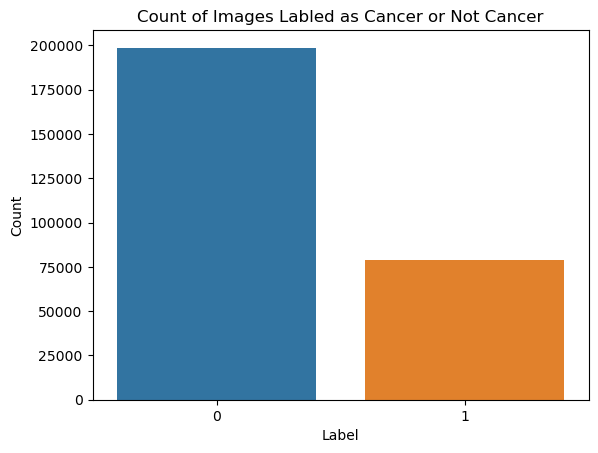

In [9]:
#plot to see how many images are labeled 0 or 1
sns.countplot(x='Label', data=image_dataframe)

#actual count of how many images are labeled 0 or 1
print(image_dataframe.Label.value_counts())
plt.title('Count of Images Labled as Cancer or Not Cancer')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('count_images_labels.png')
#plt.show()

In [10]:
image_dataframe.head()

,Patient_ID,Label,Image_Path
0,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
1,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
2,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
3,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...
4,9036,0,/Users/annaparton/Desktop/Springboard/Breast_C...


Created a bar plot to show the number of images per patient as wanted to see the distribution. 

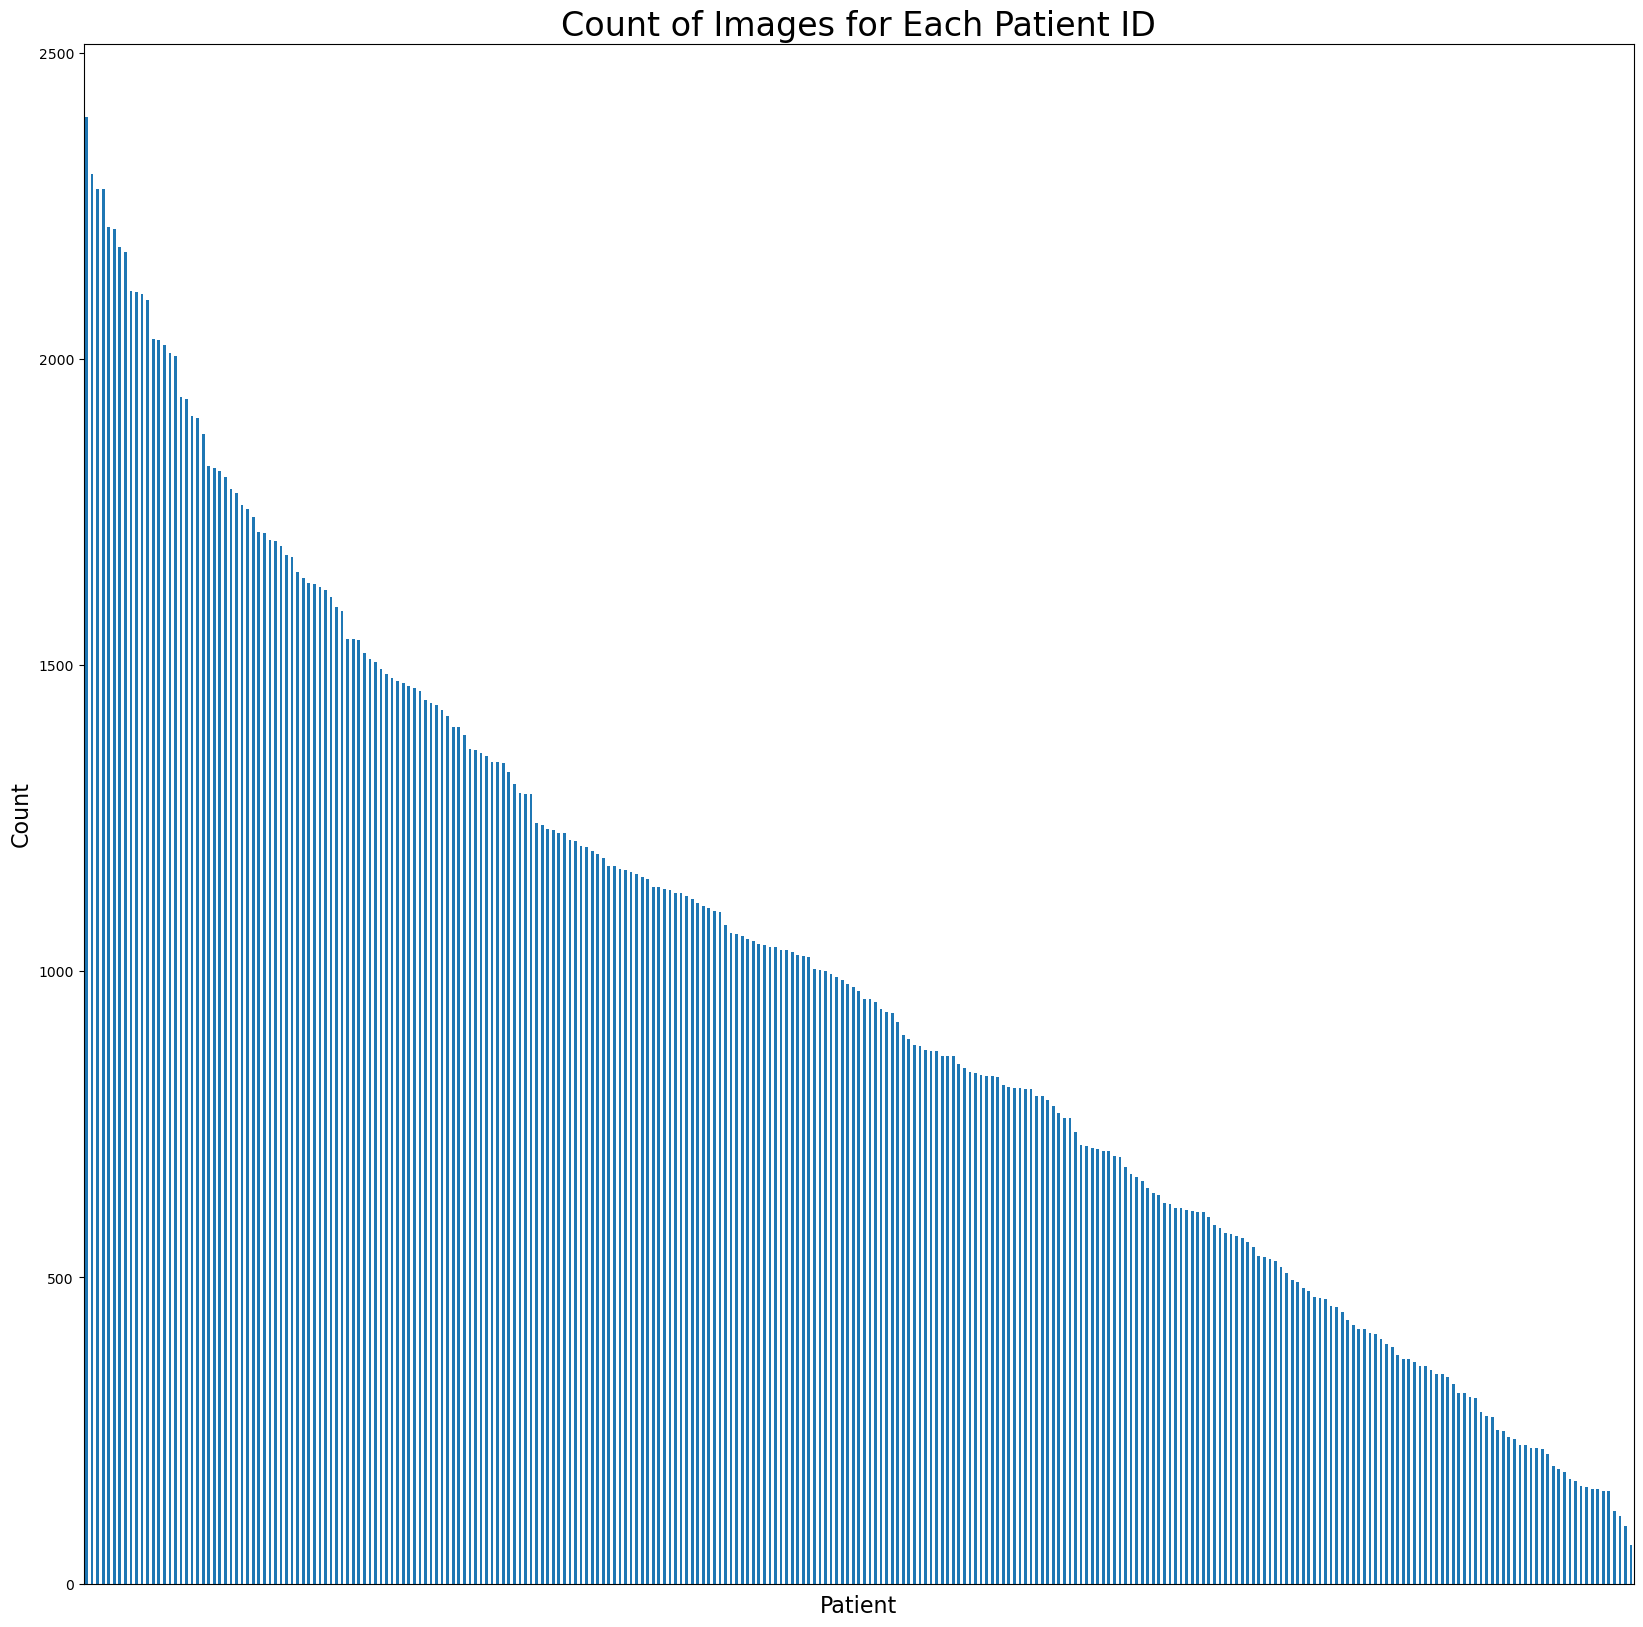

In [11]:
#actual count of how many images are labeled 0 or 1
patient_count_images= image_dataframe.Patient_ID.value_counts()

#quick glance to see if have the same number of patches for each patient
plt.figure(figsize=(20, 20))
patient_count_images.plot(kind='bar')
plt.title('Count of Images for Each Patient ID', fontsize=24)
plt.xticks([])  
plt.xlabel('Patient', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('count_images.png')
#plt.show()

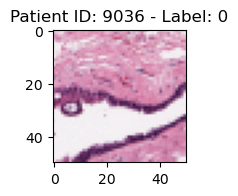

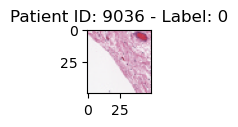

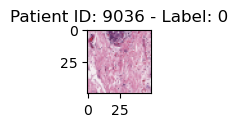

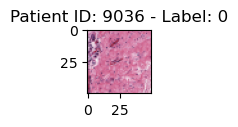

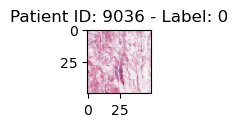

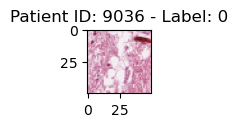

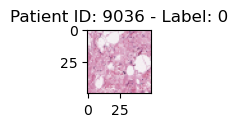

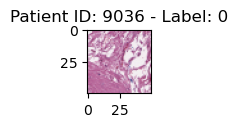

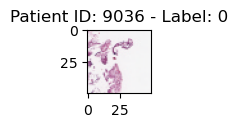

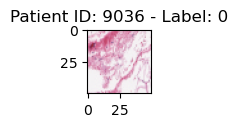

In [12]:
#plot the first 10 images (IDC negative)
import PIL
from PIL import Image

plt.figure(figsize=(10,10))

for index, row in image_dataframe.head(10).iterrows() :
    #get contents for patient_id, label and image_path
    #iterrows used to iterate over a Pandas Dataframe rows in the form of (index, series) pair AND rows indices is called index
    image_path = row['Image_Path']
    label = row['Label']
    patient= row['Patient_ID']
    #plot images
    plt.subplot(5,5,index+1) 

    #Image.open = opens and identifies the given image file
    img = Image.open(image_path)

    #imshow from matplotlib library is used to display data as an image
    plt.imshow(img)
    plt.title(f'Patient ID: {patient} - Label: {label}')
    plt.show()


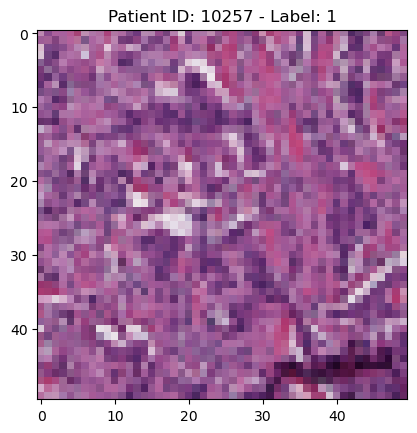

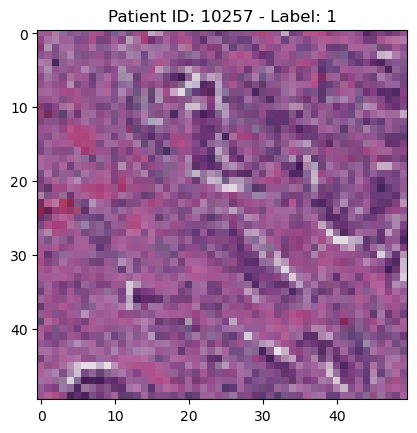

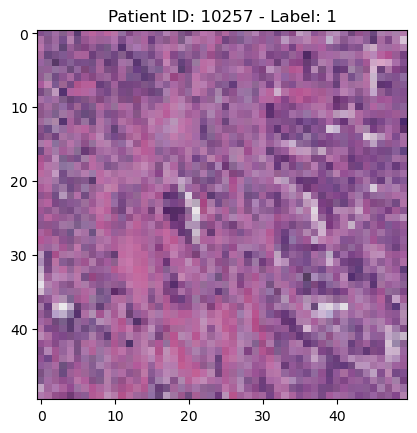

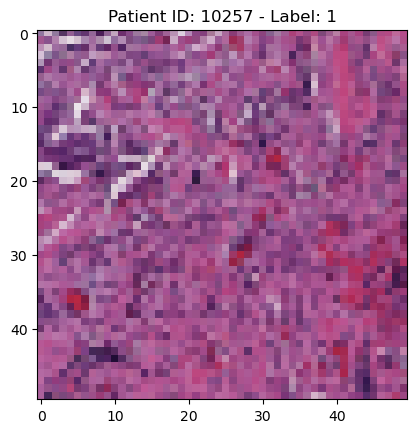

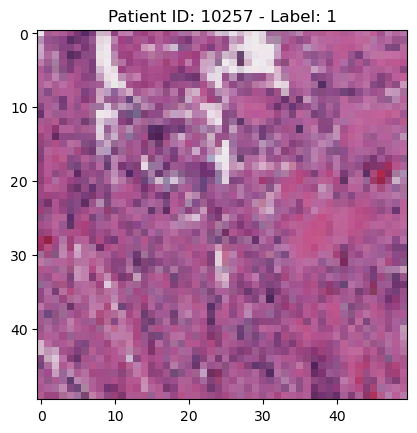

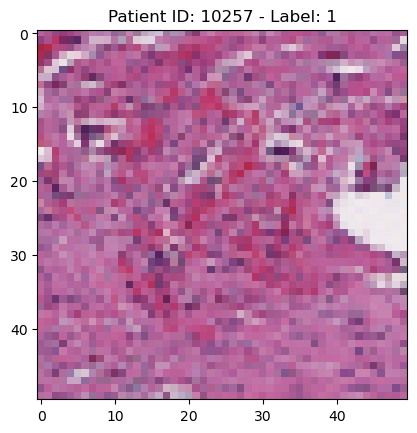

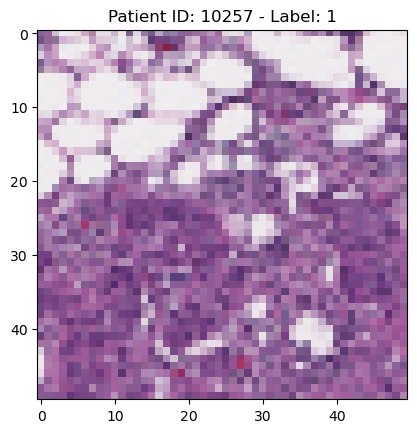

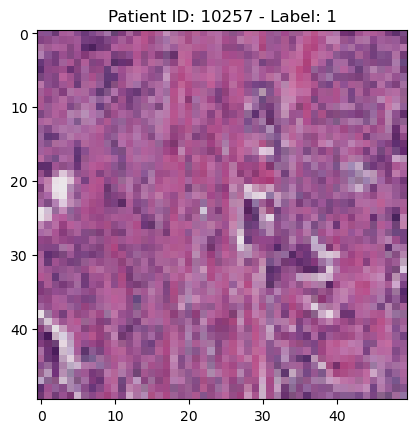

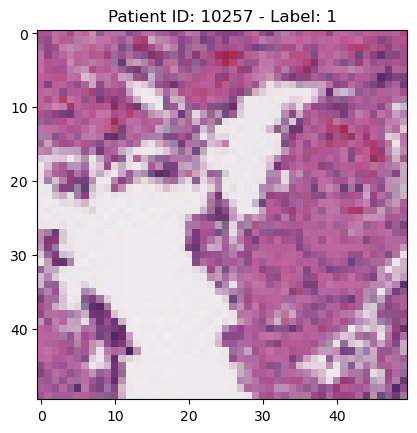

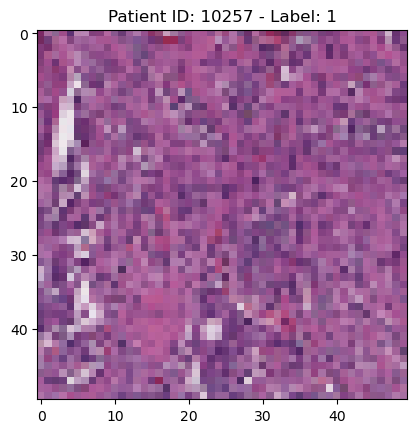

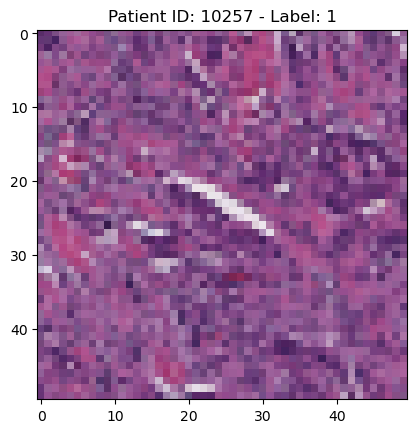

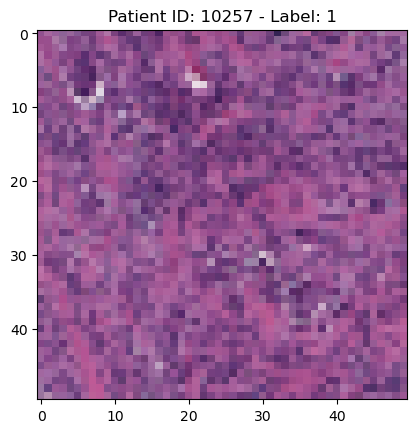

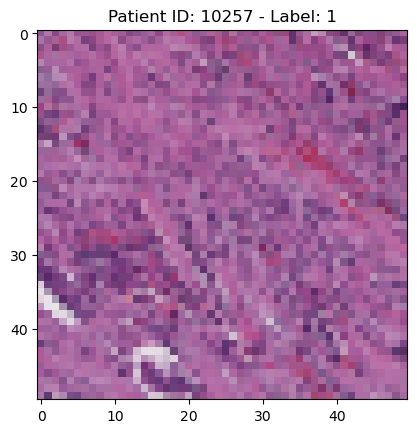

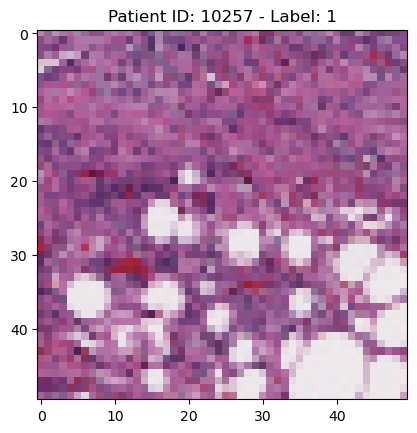

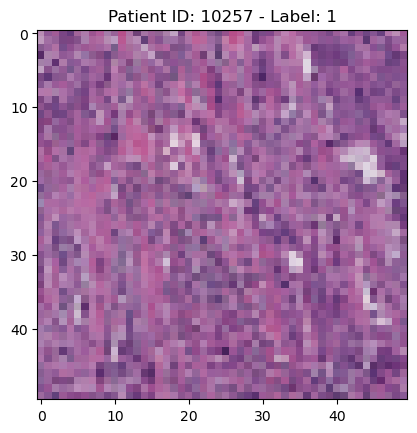

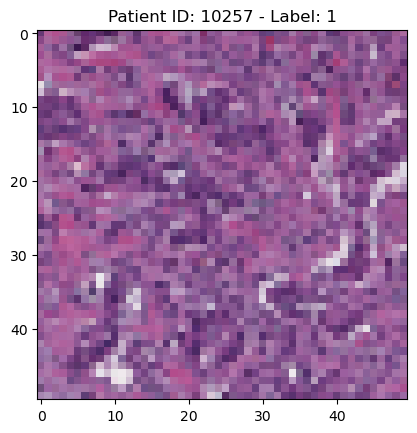

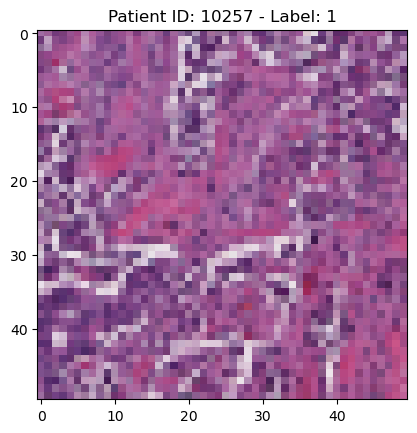

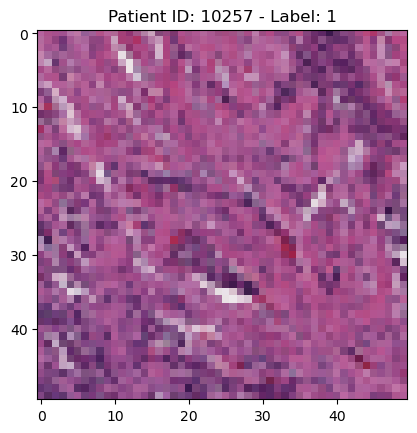

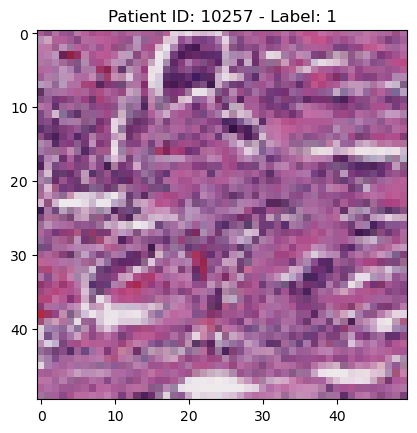

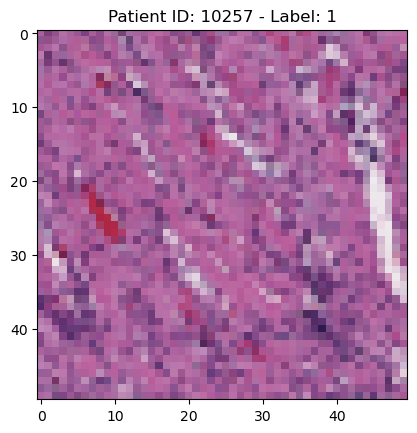

In [13]:
#plot 10 more images that are IDC positive
for index, row in image_dataframe[4000:4020].iterrows() :
    #get contents for patient_id, label and image_path 
    #iterrows used to iterate over a Pandas Dataframe rows in the form of (index, series) pair AND rows indices is called index
    image_path = row['Image_Path']
    label = row['Label']
    patient= row['Patient_ID']
    
    #plot images
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f'Patient ID: {patient} - Label: {label}')
    plt.show()


Randomly sampled and retained one-fourth of the dataset for further analysis.

In [14]:
# Select a portion of the data so not to crash (this will take a random sample)
fraction = 0.25  
sampled_df = image_dataframe.sample(frac=fraction, random_state=42) 

# 4. Preprocess Data

Normalized the images, ensuring pixel values fell within the range of 0 to 1.

In [15]:
def preprocess_image(image_path):
    #loads an image from the specified file.
    img = cv2.imread(image_path)
    target_size = (50, 50)
    #sometimes resize image but really didn't have to do this
    img = cv2.resize(img, target_size)
    #changing values to be float and between 0 to 1
    img = img.astype(np.float32) / 255.0
    return img

In [16]:
#executing function above to a single column
sampled_df['Processed_Image'] = sampled_df['Image_Path'].apply(preprocess_image)

In [17]:
sampled_df.isna().sum()

Patient_ID         0
Label              0
Image_Path         0
Processed_Image    0
dtype: int64

In [18]:
#create X, y to prepare the two classes (0 , 1) to be balanced
X= sampled_df.drop('Label', axis=1)
y= sampled_df['Label']
print(X.head())
print(y.value_counts())

       Patient_ID                                         Image_Path  \
226235      10304  /Users/annaparton/Desktop/Springboard/Breast_C...   
152659      10291  /Users/annaparton/Desktop/Springboard/Breast_C...   
261626      10282  /Users/annaparton/Desktop/Springboard/Breast_C...   
124524      10272  /Users/annaparton/Desktop/Springboard/Breast_C...   
82033       16896  /Users/annaparton/Desktop/Springboard/Breast_C...   

                                          Processed_Image  
226235  [[[0.8627451, 0.8156863, 0.85490197], [0.76862...  
152659  [[[0.77254903, 0.6627451, 0.79607844], [0.9019...  
261626  [[[0.5137255, 0.2901961, 0.8156863], [0.525490...  
124524  [[[0.9372549, 0.9254902, 0.9411765], [0.941176...  
82033   [[[0.59607846, 0.4392157, 0.73333335], [0.7764...  
0    49676
1    19705
Name: Label, dtype: int64


The data is not balanced so will:
    1. Oversample the minority class to ~50% of the same amount as the majority
    2. Undersample the majority class to have equal amounts

In [19]:
#first will oversample
ros = RandomOverSampler(sampling_strategy=.45, random_state= 42)
X_over, y_over = ros.fit_resample(X, y)

0    49676
1    22354
Name: Label, dtype: int64


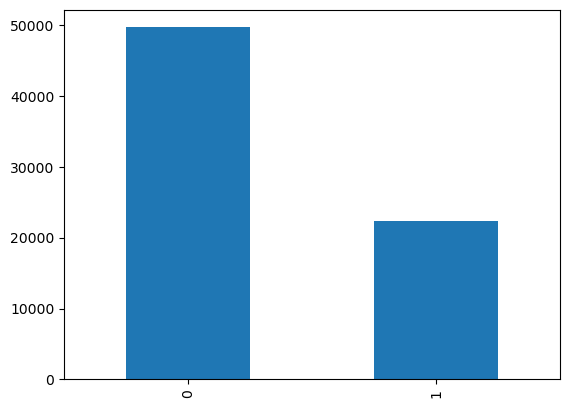

In [20]:
#plot to see how many images are labeled 0 or 1
y_over.value_counts().plot(kind='bar')
print(y_over.value_counts())

#values before this were {0: 49676, 1:19705}

In [21]:
#undersample the majority 
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_over, y_over)

0    22354
1    22354
Name: Label, dtype: int64


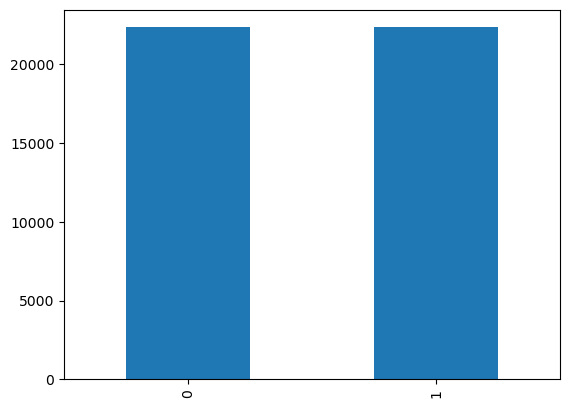

In [22]:
#plot to make sure now even
y_under.value_counts().plot(kind='bar')
print(y_under.value_counts())

#values before this were {0: 49676, 1:22354}
#looking to use ~44000 instead of ~300000

In [23]:
X_image = X_under[['Processed_Image']]
print(type(X_image))
print(X_image.head())

<class 'pandas.core.frame.DataFrame'>
                                         Processed_Image
62974  [[[0.41960785, 0.19607843, 0.3647059], [0.3882...
42710  [[[0.6313726, 0.46666667, 0.79607844], [0.5960...
13014  [[[0.79607844, 0.7176471, 0.91764706], [0.7882...
16148  [[[0.75686276, 0.68235296, 0.8784314], [0.7294...
37955  [[[0.89411765, 0.8627451, 0.94509804], [0.8823...


Transformed images (pixel values) into numpy arrays, preparing them for the CNN model.
1. List comprehension - iterated over each entry in the 'Processed_Image' column, converting each 3D array into a NumPy array. 
2. The resulting list of NumPy arrays is then converted into a single NumPy array. This creates a 4D array (number of images, height, width, channels). 

In [24]:
#convert X_image into numpy array to be ready for CNN modeling
X_numpy = np.array([np.array(img) for img in X_image['Processed_Image']])

In [25]:
X_numpy[0:5]

array([[[[0.41960785, 0.19607843, 0.3647059 ],
         [0.3882353 , 0.19215687, 0.36078432],
         [0.45882353, 0.2509804 , 0.3882353 ],
         ...,
         [0.39607844, 0.18431373, 0.38039216],
         [0.6039216 , 0.4392157 , 0.79607844],
         [0.54901963, 0.3764706 , 0.8156863 ]],

        [[0.654902  , 0.5019608 , 0.7254902 ],
         [0.5411765 , 0.33333334, 0.5686275 ],
         [0.5529412 , 0.34509805, 0.5882353 ],
         ...,
         [0.63529414, 0.45882353, 0.7607843 ],
         [0.5058824 , 0.29411766, 0.5803922 ],
         [0.5803922 , 0.4       , 0.79607844]],

        [[0.7490196 , 0.64705884, 0.7882353 ],
         [0.7647059 , 0.6313726 , 0.8117647 ],
         [0.7137255 , 0.56078434, 0.78431374],
         ...,
         [0.5686275 , 0.37254903, 0.6862745 ],
         [0.49803922, 0.30980393, 0.60784316],
         [0.5764706 , 0.4       , 0.78039217]],

        ...,

        [[0.5058824 , 0.33333334, 0.8       ],
         [0.6156863 , 0.45490196, 0.8509804 ]

Split the data into training and testing datasets. Will use .1 of the training data as validation data. 

In [26]:
#first split the data into training (.8) and testing (.2)
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_under, test_size=0.2, random_state=1)

In [27]:
# (35766, 50, 50, 3) refers to (number_of_images, height, width, channels) where 3 channels means red, green and blue
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(35766, 50, 50, 3)
(35766,)
(8942, 50, 50, 3)


# 5. Model

Model 1

In [28]:
#Model 1
model = Sequential()

2024-01-17 19:41:14.081553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
#convolution layers followed by maxpooling layers
model.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D())
model.add(Conv2D(8, (2,2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(8, (2,2), 1, activation='relu'))
model.add(MaxPooling2D())

#flatten output into one large vector that will feed into the fully connected layer (hidden layer)
model.add(Flatten())

#fully connected classifier
#Dense refers "fully connected layer"
model.add(Dense(256, activation='relu'))

#use sigmoid function as detecting if IDC positive
model.add(Dense(1, activation='sigmoid'))

In [32]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report

#used the 'adam' optimizer due to having a faster computation time and generally performs well
#Binary cross-entropy loss is used for binary (0 or 1) classification tasks

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 49, 49, 8)         104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 8)         264       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 8)         264       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 8)          0

In [34]:
#fit the model to the data and use validation_split argument to section off
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
1006/1006 [==============================] - 7s 7ms/step - loss: 0.4894 - accuracy: 0.7708 - val_loss: 0.4500 - val_accuracy: 0.7956
Epoch 2/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.4405 - accuracy: 0.8052 - val_loss: 0.4327 - val_accuracy: 0.8010
Epoch 3/20
1006/1006 [==============================] - 7s 7ms/step - loss: 0.4240 - accuracy: 0.8129 - val_loss: 0.4304 - val_accuracy: 0.8018
Epoch 4/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.4178 - accuracy: 0.8165 - val_loss: 0.4207 - val_accuracy: 0.8116
Epoch 5/20
1006/1006 [==============================] - 7s 7ms/step - loss: 0.4116 - accuracy: 0.8202 - val_loss: 0.4072 - val_accuracy: 0.8110
Epoch 6/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.4041 - accuracy: 0.8225 - val_loss: 0.4085 - val_accuracy: 0.8096
Epoch 7/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.4023 - accuracy: 0.8228 - val_loss: 0.4023 - val_accuracy:

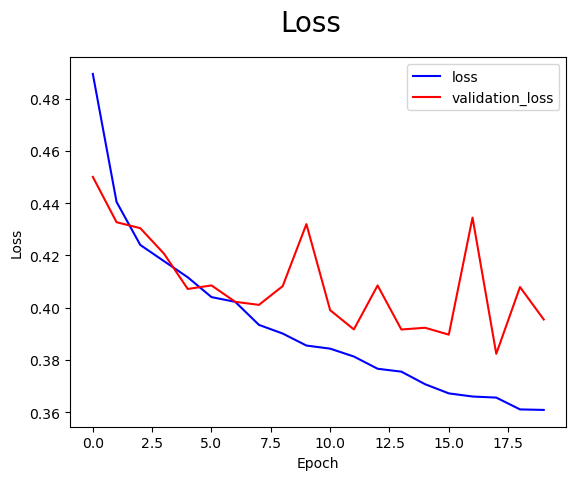

In [35]:
#plotting the loss for training and validation data
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='red', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.savefig('loss.png')
#plt.show()

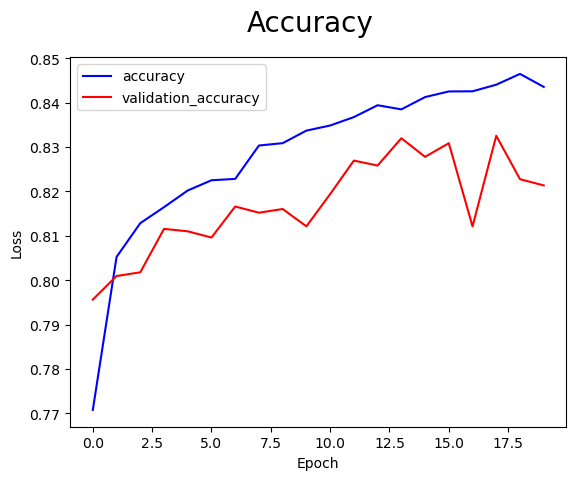

In [36]:
#plotting the accuracy for training and validation data
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='red', label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('accuracy.png')
#plt.show()

In [37]:
#what is the loss and accuracy of the testing data
score = model.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.388843297958374
Test accuracy:  0.8325877785682678


In [38]:
print(score)

[0.388843297958374, 0.8325877785682678]


Plotting the ROC curve and finding the AUC score for model as better metrics than accuracy and loss for this data. 

In [39]:
from sklearn.metrics import roc_curve
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

280/280 [==============================] - 1s 3ms/step


In [42]:
from sklearn.metrics import auc
auc_model1 = auc(fpr, tpr)
auc_model1

0.9087062632292362

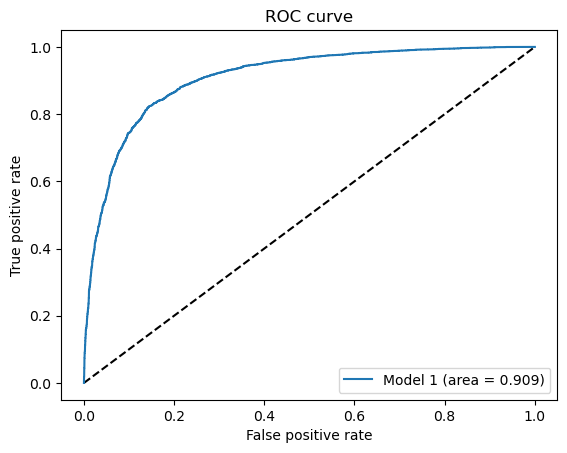

In [41]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Model 1 (area = {:.3f})'.format(auc_model1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Model 2 - changing second convolution layer to have 16 filters. 

In [62]:
model2 = Sequential()

In [63]:
#building layers
model2.add(Conv2D(8, (2,2), 1, activation='relu', input_shape=(50,50,3)))
model2.add(MaxPooling2D())
model2.add(Conv2D(16, (2,2), 1, activation='relu'))
model2.add(MaxPooling2D())
model2.add(Conv2D(8, (2,2), 1, activation='relu'))
model2.add(MaxPooling2D())

#flatten output
model2.add(Flatten())
#fully connected classifier
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [64]:
model2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [65]:
#fit the model to the data and use validation_split argument to section off
history2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
1006/1006 [==============================] - 7s 7ms/step - loss: 0.4822 - accuracy: 0.7758 - val_loss: 0.4486 - val_accuracy: 0.8001
Epoch 2/20
1006/1006 [==============================] - 7s 7ms/step - loss: 0.4350 - accuracy: 0.8093 - val_loss: 0.4594 - val_accuracy: 0.7917
Epoch 3/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.4220 - accuracy: 0.8141 - val_loss: 0.4422 - val_accuracy: 0.7973
Epoch 4/20
1006/1006 [==============================] - 7s 6ms/step - loss: 0.4104 - accuracy: 0.8212 - val_loss: 0.4345 - val_accuracy: 0.8029
Epoch 5/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.4018 - accuracy: 0.8256 - val_loss: 0.4170 - val_accuracy: 0.8197
Epoch 6/20
1006/1006 [==============================] - 6s 6ms/step - loss: 0.3908 - accuracy: 0.8315 - val_loss: 0.4000 - val_accuracy: 0.8219
Epoch 7/20
1006/1006 [==============================] - 7s 7ms/step - loss: 0.3824 - accuracy: 0.8369 - val_loss: 0.3888 - val_accuracy:

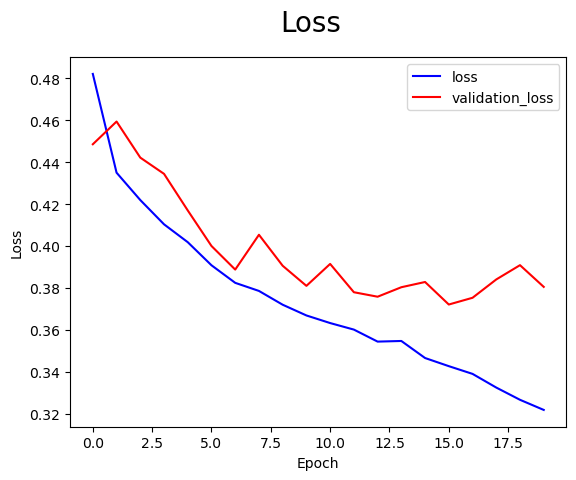

In [66]:
#plotting the loss for training and validation data for model 2
fig = plt.figure()
plt.plot(history2.history['loss'], color='blue', label='loss')
plt.plot(history2.history['val_loss'], color='red', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

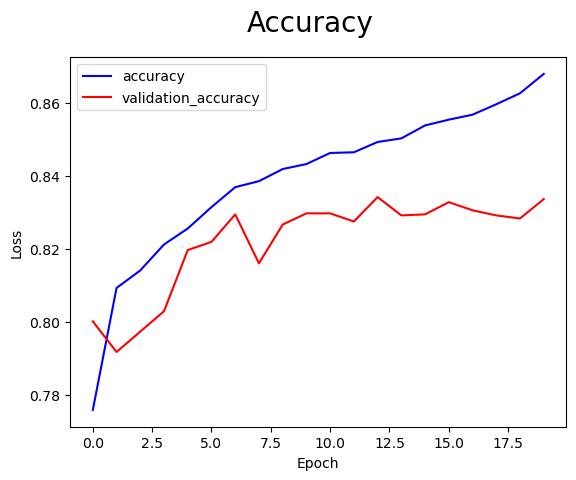

In [67]:
#plotting the accuracy for training and validation data for model 2
fig = plt.figure()
plt.plot(history2.history['accuracy'], color='blue', label='accuracy')
plt.plot(history2.history['val_accuracy'], color='red', label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [68]:
score = model2.evaluate(X_test, y_test, verbose = 0 )
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.36977410316467285
Test accuracy:  0.8475732207298279


In [69]:
#getting values to plot ROC curve
y_pred2 = model2.predict(X_test).ravel()
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)

280/280 [==============================] - 1s 3ms/step


In [70]:
#AUC metric 
auc_model2 = auc(fpr2, tpr2)
auc_model2

0.9175690261481146

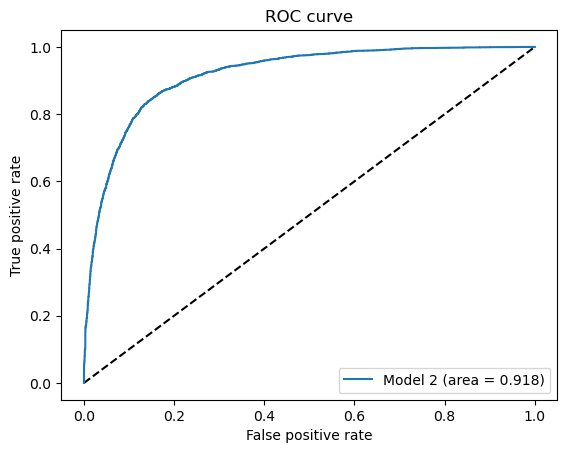

In [71]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label='Model 2 (area = {:.3f})'.format(auc_model2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()